<a href="https://colab.research.google.com/github/astroChance/RadNET/blob/master/RadNET_64x64_FullWorkflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Data Loading

In [1]:
!pip install --upgrade segyio
import segyio
import numpy as np
# from math import sqrt
import matplotlib
import matplotlib.pyplot as plt
import time
# import itertools
import os
import re
import random
# from PIL import Image
from scipy import spatial, signal
import json
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from IPython import display
import datetime
import tensorflow as tf

     |████████████████████████████████| 92kB 4.6MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Numpy file generation

In [ ]:
#--------------------------------------------------
##################
## Variables and parameters
file_counter=0
num_files = 5000
trace_list_2D = []  # comment out if building with multiple runs)
    
input_dimension = (64, 64)  
input_data_2D = np.zeros((num_files, input_dimension[0], input_dimension[1]))
input_data_3D = np.zeros((num_files, input_dimension[0], input_dimension[1]))

trace_len_clip_2D_start = 1970   # Trimming 2D data to approximately match 3D
trace_len_clip_2D_end = 3040

# Zxx parameters
fs = 1 / 0.0000000375     #sample frequency
nperseg = 127        # nperseg/noverlap combo produces 64x32 assuming 1070 samples
noverlap = 92
window = signal.hann(nperseg, sym=False)

#--------------------------------------------------



##################
## Seismic Data filepaths
## Loading trace match dictionary

Volume3D = "/content/drive/My Drive/RadNET/GAN data/3D/PB3D_Fritz_subset.sgy"

TwoDFiles = []
for root, dirs, files in os.walk("/content/drive/My Drive/RadNET/GAN data/2D"):
    for name in files:
        filename = os.path.join(root, name)
        TwoDFiles.append(filename)
# print("2D files in directory: ", len(TwoDFiles))

Trace_Map_Dict = "/content/drive/My Drive/RadNET/GAN data/2D_to_3D_Trace_Dict.json"
with open(Trace_Map_Dict, 'r') as TraceDictFile:
    TraceDict = json.load(TraceDictFile)



##################
## Get 2D and 3D traces randomly
## Perform STFT
## Shape and scale arrays

while file_counter < num_files:
    
    # Randomly choose value from trace match dictionary
    Rand2D = random.choice(list(TraceDict.items()))
    RandTraceMatch = random.choice(list(Rand2D[1].items()))

    # Set the random choice to variables, print information
    # The dictionary captures trace numbers from TRACE_SEQUENCE_LINE,
    # which compared to the numpy array is index + 1, therefore need to 
    # subtract 1 to get the proper index value
    Rand2DLine = int(Rand2D[0])
    Rand2DTrace = int(RandTraceMatch[0])-1
    Rand3DTrace = int(RandTraceMatch[1][0])-1
    
    # check if we've already grabbed the random trace
    if (str(Rand2DLine)+str(Rand2DTrace)) in trace_list_2D:
        continue
    trace_list_2D.append(str(Rand2DLine)+str(Rand2DTrace))
    
    # Get the random 2D trace data
    Rand2DFile = "/content/drive/My Drive/RadNET/GAN data/2D/" + str(Rand2DLine) + ".sgy"
    with segyio.open(Rand2DFile, 'r') as segyfile:
        display_trace_2D = segyfile.trace[Rand2DTrace]
        display_trace_2D = display_trace_2D[1trace_len_clip_2D_start:trace_len_clip_2D_end]

    # Check for dead 2D traces
    if np.amax(display_trace_2D) < -100:
        continue

    # Get the random (matched) 3D trace data
    with segyio.open(Volume3D, 'r') as segyfile:
        display_trace_3D = segyfile.trace[Rand3DTrace]

    # Using StandardScaler to adjust relative ampltidues of 2D and 3D
    scaler2D = StandardScaler()    
    scaler3D = StandardScaler()
    standardized_2D_trace = np.squeeze(scaler2D.fit_transform(display_trace_2D.reshape((len(display_trace_2D), 1))))
    standardized_3D_trace = np.squeeze(scaler3D.fit_transform(display_trace_3D.reshape((len(display_trace_3D), 1))))

    # Perform STFT
    _, _, Zxx2D = signal.stft(standardized_2D_trace, window = window, fs = fs, nperseg = nperseg, noverlap=noverlap)
    _, _, Zxx3D = signal.stft(standardized_3D_trace, window = window, fs = fs, nperseg = nperseg, noverlap=noverlap)

    # Shape and scale data
    Mag_2D = np.abs(Zxx2D)
    Mag_2D = np.repeat(Mag_2D, 2, axis=1)
    Mag_2D = np.log(Mag_2D)
    
    Mag_3D = np.abs(Zxx3D)
    Mag_3D = np.repeat(Mag_3D, 2, axis=1)
    Mag_3D = np.log(Mag_3D)
    
    # Place data into holder arrays
    input_data_2D[file_counter, :, :] = Mag_2D
    input_data_3D[file_counter, :, :] = Mag_3D
    
    file_counter+=1

## Load data Numpy files, create Dataset

In [5]:
##################
## Load numpy files
## Create Tensorflow Dataset
start = time.time()


input_data_dir_2D = "/content/drive/My Drive/RadNET/GAN data/Spec_Numpy_Arrays/Training/2D"
input_data_dir_3D = "/content/drive/My Drive/RadNET/GAN data/Spec_Numpy_Arrays/Training/3D"

numpy_filepaths_2D = []
for root, dirs, files in os.walk(input_data_dir_2D):
    for name in files:
        if name.endswith('.npy'):
            filename = os.path.join(root, name)
            numpy_filepaths_2D.append(filename)

numpy_filepaths_3D = []
for root, dirs, files in os.walk(input_data_dir_3D):
    for name in files:
        if name.endswith('.npy'):
            filename = os.path.join(root, name)
            numpy_filepaths_3D.append(filename)

assert len(numpy_filepaths_2D) == len(numpy_filepaths_3D), 'Check 2D and 3D filepaths'

input_dimension = (64, 64)
specs_per_training_file = 5000  
input_data_2D_holder = np.zeros((specs_per_training_file*len(numpy_filepaths_2D), input_dimension[0], input_dimension[1]))
input_data_3D_holder = np.zeros((specs_per_training_file*len(numpy_filepaths_3D), input_dimension[0], input_dimension[1]))



for N in range(len(numpy_filepaths_2D)):
    tmp_2D_arr = np.load(numpy_filepaths_2D[N])
    tmp_3D_arr = np.load(numpy_filepaths_3D[N])

    insertion_idx = N * specs_per_training_file

    input_data_2D_holder[insertion_idx:insertion_idx + specs_per_training_file, :, :] = tmp_2D_arr
    input_data_3D_holder[insertion_idx:insertion_idx + specs_per_training_file, :, :] = tmp_3D_arr



# Create Tensor Dataset

BATCH_SIZE = 64

data_tf_2D = tf.convert_to_tensor(input_data_2D_holder, np.float32)
data_tf_3D = tf.convert_to_tensor(input_data_3D_holder, np.float32)

train_dataset2d = tf.data.Dataset.from_tensor_slices(data_tf_2D)
train_dataset2d = train_dataset2d.batch(BATCH_SIZE)

train_dataset3d = tf.data.Dataset.from_tensor_slices(data_tf_3D)
train_dataset3d = train_dataset3d.batch(BATCH_SIZE)

del input_data_2D_holder
del input_data_3D_holder

end = time.time()
print("Time to completion (s): ", round(end-start))

Time to completion (s):  27.78783345222473


# Model

## Architecture

In [6]:
# Define discriminator and generator models
# Define loss and optimizers
# Instantiate models


BATCH_SIZE = 64

OUTPUT_CHANNELS = 1

def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result


def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result


def Generator():
    inputs = tf.keras.layers.Input(shape=[input_dimension[0], input_dimension[1], OUTPUT_CHANNELS])
        
    down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 32, 32, 64)
    downsample(128, 4), # (bs, 16, 16, 128)
    downsample(256, 4), # (bs, 8, 8, 256)
#     downsample(512, 4), # (bs, 4, 4, 512)
#     downsample(512, 4), # (bs, 2, 2, 512)
#     downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 16, 16, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 32, 32, 1024)
#     upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
#     upsample(512, 4), # (bs, 16, 16, 1024)
#     upsample(256, 4), # (bs, 32, 32, 512)
#     upsample(128, 4), # (bs, 64, 64, 256)
#     upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)
  
    x = inputs
    
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)


def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    
    inp = tf.keras.layers.Input(shape=[input_dimension[0], input_dimension[1], OUTPUT_CHANNELS], name='input_image')
    tar = tf.keras.layers.Input(shape=[input_dimension[0], input_dimension[1], OUTPUT_CHANNELS], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)


# define loss and optimizers

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
LAMBDA = 100

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss



generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


# Instantiate the models 
generator = Generator()
discriminator = Discriminator()

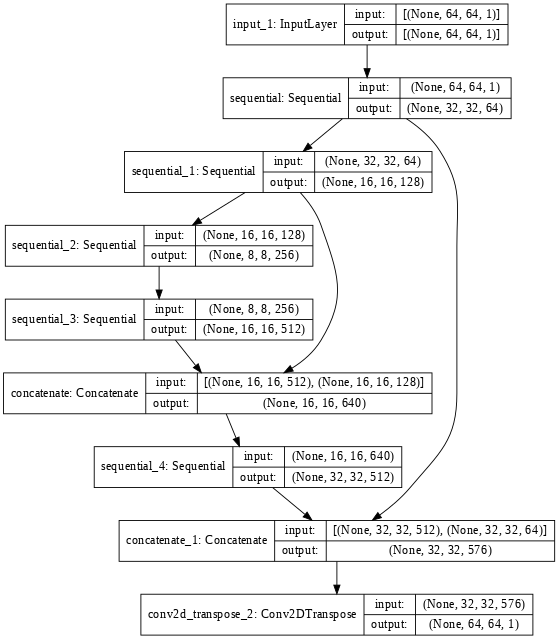

In [8]:
## Display graphical model description

# Generator().summary()
# Discriminator().summary()

tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)
# tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

## Define Training Steps and Checkpoints

In [9]:
# set up checkpoints and define training / fit steps

# log_dir="/content/drive/My Drive/RadNET/logs/"

# summary_writer = tf.summary.create_file_writer(
#   log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

checkpoint_dir = '/content/drive/My Drive/RadNET/training_checkpoints/Production_Run1'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))
  
def fit(train_3d, train_2d, epochs, chkpt_save):
    for epoch in range(epochs):
        display.clear_output(wait=True)
        try:
            print ('Time taken for epoch {} was {} sec\n'.format(epoch - 1,
                                                        time.time()-start))
        except:
            pass

        start = time.time()
        print("Epoch ", epoch, " running...")

        n=0
        # Train (separate Datasets for input and target)
        for input_image, target in tf.data.Dataset.zip((train_3d, train_2d)):
            train_step(input_image, target, epoch)
            if (n+1) % 100 == 0:
                print('.', end='')
            n +=1 
    
        print()

        


    # saving (checkpoint) the model every chkpt_save epochs
        if (epoch + 1) % chkpt_save == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

    checkpoint.save(file_prefix = checkpoint_prefix)

# Model Training

In [ ]:
# Load latest checkpoint if picking up / continuing training 
# Skip if starting from scratch

checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [10]:
# Define how many epochs to run model
EPOCHS = 500
chkpt_save = 100

# Run the model
fit(train_dataset3d, train_dataset2d, EPOCHS, chkpt_save)

print("Training Complete!")

Epoch  0  running...
....

ValueError: ignored